In [88]:
"""Module 4: Time Series Analysis and EOF Analysis.

Load and process ERA5 SST and TCWV data for EOF analysis.
"""

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from eofs.xarray import Eof

# Load the NetCDF file
DS_FILE = "c65ce3e3ce9eb32eeaae895091849af4.nc"
ds = xr.open_dataset(DS_FILE)
print("Dataset loaded:")
print(ds)


Dataset loaded:
<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 561, latitude: 521, longitude: 721)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2025-09-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB -240.0 -239.8 -239.5 ... -60.25 -60.0
    expver      (valid_time) <U4 9kB ...
Data variables:
    sst         (valid_time, latitude, longitude) float32 843MB ...
    tcwv        (valid_time, latitude, longitude) float32 843MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-24T22:25 GRIB to CDM+CF via cfgrib-0.9.1...


In [89]:
# Define helper functions for detrending and anomaly calculation

def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    """Convert time to float seconds since first timestamp."""
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})
        mask = da.notnull()
        t_b = t.broadcast_like(da)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

In [90]:
"""Data processing: Linear detrending and anomaly calculation.

Load data without dask chunking to avoid chunking inconsistencies.
"""

# Constants
BASE_PERIOD = ("1979-01-01", "2020-12-31")
TIME_DIM = "valid_time"
EPSILON = 1e-6

# Load data
print("Loading data without dask chunking...")
ds_no_dask = xr.open_dataset(DS_FILE, chunks=None)
print("Dataset loaded without dask chunking")

# Linear detrending
print("Applying linear detrending...")
detr = linear_detrend(ds_no_dask[["sst", "tcwv"]], time_dim=TIME_DIM)
print("Detrending completed")

# Calculate monthly anomalies and z-scores
print("Computing monthly anomalies...")
clim_src = detr.sel({TIME_DIM: slice(*BASE_PERIOD)})

# Compute monthly climatology
clim_mean = clim_src.groupby(f"{TIME_DIM}.month").mean(
    TIME_DIM, skipna=True
)
clim_std = clim_src.groupby(f"{TIME_DIM}.month").std(
    TIME_DIM, skipna=True, ddof=1
)

# Compute anomalies
anom = detr.groupby(f"{TIME_DIM}.month") - clim_mean

# Compute z-scores
safe_std = xr.where(clim_std > EPSILON, clim_std, np.nan)
z = anom.groupby(f"{TIME_DIM}.month") / safe_std

print("Success! Anomaly calculation completed.")
print(f"Anomaly dataset: {type(anom)} with variables: {list(anom.data_vars)}")
print(f"Z-score dataset: {type(z)} with variables: {list(z.data_vars)}")

Loading data without dask chunking...
Dataset loaded without dask chunking
Applying linear detrending...


Detrending completed
Computing monthly anomalies...


/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 

Success! Anomaly calculation completed.
Anomaly dataset: <class 'xarray.core.dataset.Dataset'> with variables: ['sst', 'tcwv']
Z-score dataset: <class 'xarray.core.dataset.Dataset'> with variables: ['sst', 'tcwv']


In [93]:
"""EOF Analysis of SST Anomalies."""

# Constants
N_EOFS = 10

print("Starting EOF analysis...")

# Extract SST anomalies for EOF analysis
sst_anom = anom['sst']

# Compute mask to exclude gridpoints with all NaNs in time
spatial_mask = ~sst_anom.isnull().all(dim=TIME_DIM)

# Apply mask so EOF analysis is confined to ocean points
sst_masked = sst_anom.where(spatial_mask)

# Define cosine(latitude) weights following M04N05
coslat = np.cos(np.deg2rad(sst_masked.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]  # shape (lat, 1)

# Create the EOF solver using anomaly field and weights
solver = Eof(sst_masked, weights=wgts)

# Compute first 10 EOFs and their explained variance
eof_maps = solver.eofs(neofs=N_EOFS)
variance_frac = solver.varianceFraction().values[:N_EOFS]

print("EOF analysis completed successfully!")


Starting EOF analysis...
EOF analysis completed successfully!


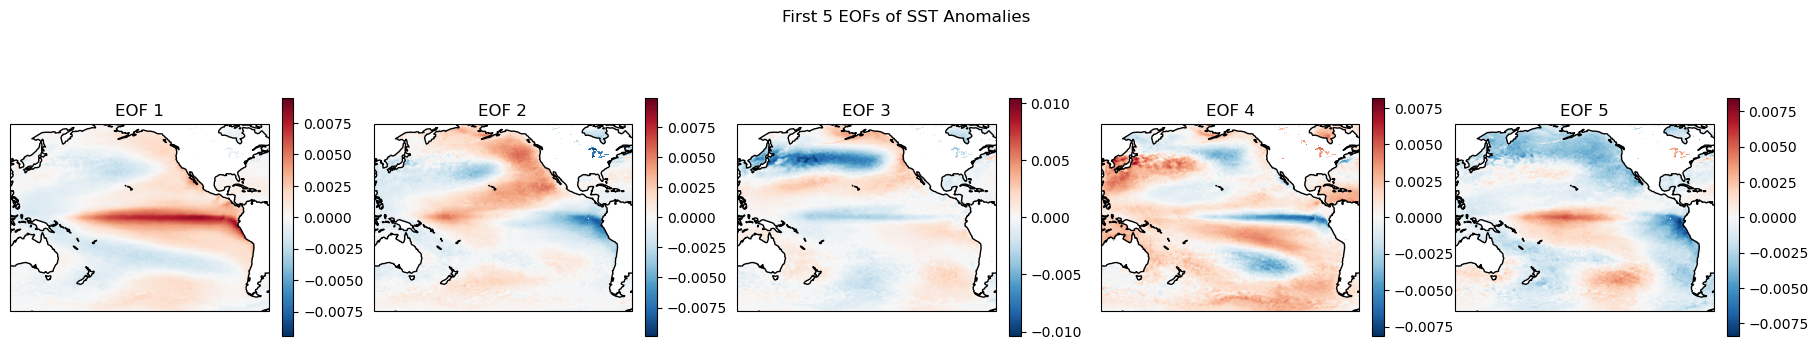

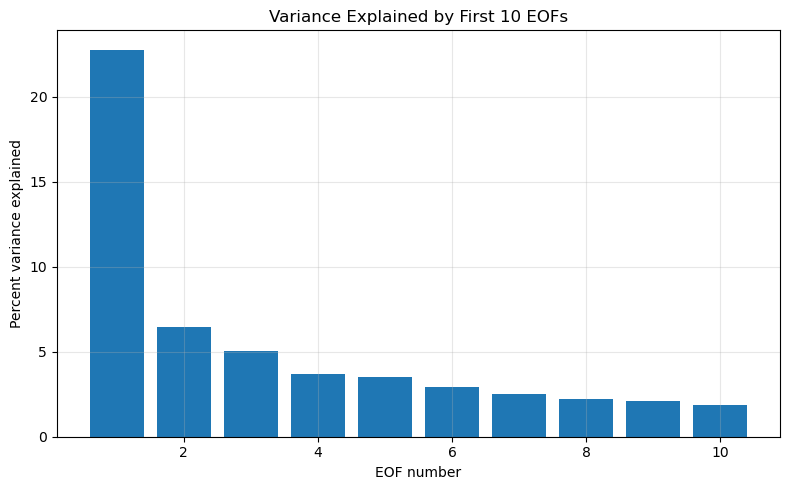

First 5 EOFs explain 41.5% of the total variance


In [94]:
"""Visualization: EOF Maps and Variance Explained."""

# Constants
N_DISPLAY_EOFS = 5
CENTRAL_LONGITUDE = 180

# Plot maps of first 5 EOFs - centered on Pacific
fig, axes = plt.subplots(
    1, N_DISPLAY_EOFS, figsize=(18, 4), constrained_layout=True,
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=CENTRAL_LONGITUDE)}
)
if not isinstance(axes, np.ndarray):
    axes = [axes]

for i, ax in enumerate(axes):
    im = eof_maps.isel(mode=i).plot.pcolormesh(
        ax=ax,
        x='longitude',
        y='latitude',
        cmap='RdBu_r',
        add_colorbar=False,
        add_labels=False,
        transform=ccrs.PlateCarree()
    )
    ax.set_title(f'EOF {i + 1}')
    ax.coastlines()
    plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.046)

plt.suptitle("First 5 EOFs of SST Anomalies")
plt.show()

# Plot percent variance explained by first 10 EOFs
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(np.arange(1, N_EOFS + 1), variance_frac * 100)
ax.set_xlabel("EOF number")
ax.set_ylabel("Percent variance explained")
ax.set_title("Variance Explained by First 10 EOFs")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

total_variance = variance_frac[:N_DISPLAY_EOFS].sum() * 100
print(f"First {N_DISPLAY_EOFS} EOFs explain {total_variance:.1f}% "
      f"of the total variance")



Reconstructing SST field using first 5 EOFs...
Computing correlation...


/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


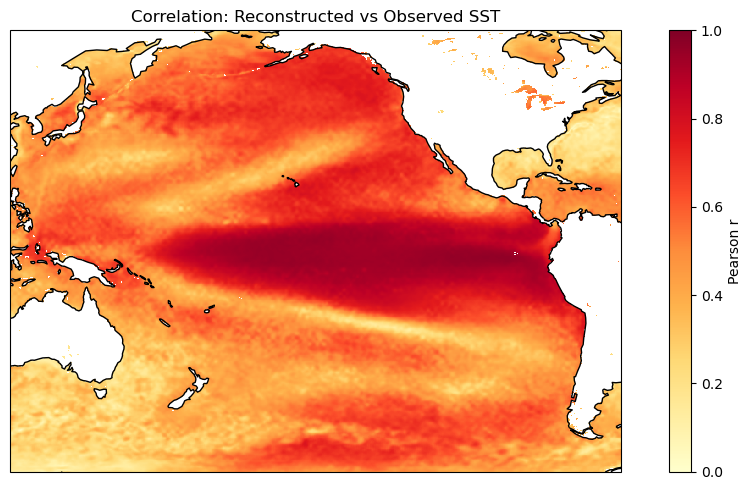

Mean correlation: 0.539
Max correlation: 0.965


In [95]:
"""Reconstruct SST field using first 5 EOFs and compute correlation."""

# Constants
N_RECON_EOFS = 5

print(f"Reconstructing SST field using first {N_RECON_EOFS} EOFs...")

# Use the proper eofs method for reconstruction
reconstruction = solver.reconstructedField(N_RECON_EOFS)

# Compute correlation
print("Computing correlation...")
corr_map = xr.corr(reconstruction, sst_anom, dim=TIME_DIM)

# Plot centered on Pacific
fig, ax = plt.subplots(
    figsize=(10, 5),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=CENTRAL_LONGITUDE)}
)
corr_map.plot(
    ax=ax,
    vmin=0,
    vmax=1,
    cmap='YlOrRd',
    cbar_kwargs={'label': "Pearson r"},
    transform=ccrs.PlateCarree()
)
ax.set_title("Correlation: Reconstructed vs Observed SST")
ax.coastlines()
plt.tight_layout()
plt.show()

print(f"Mean correlation: {corr_map.mean().values:.3f}")
print(f"Max correlation: {corr_map.max().values:.3f}")


Computing correlation between SST EOF1 and TCWV anomalies...
Computing PC1 manually...


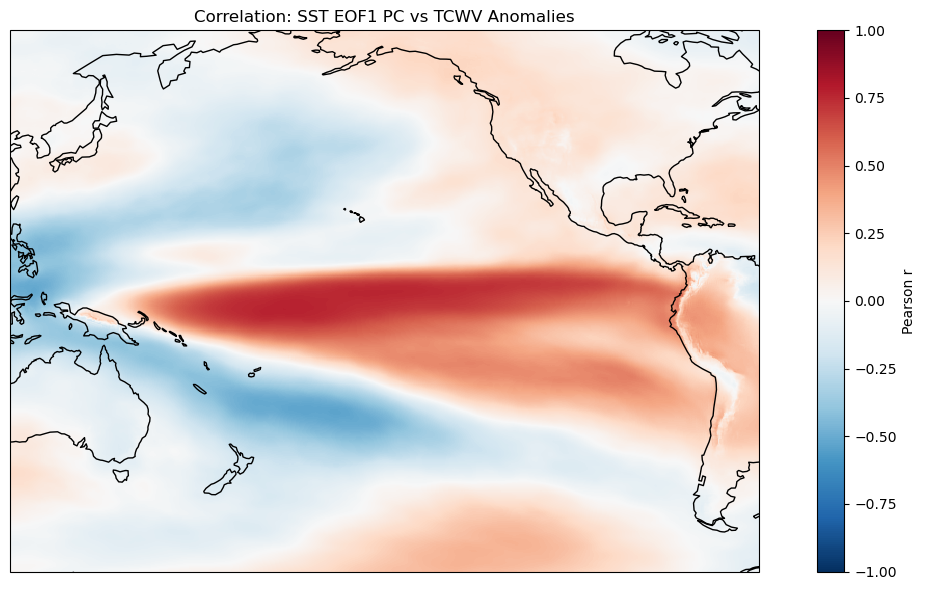

Mean correlation: 0.053
Max correlation: 0.774
Min correlation: -0.536


In [96]:
"""Correlation between SST EOF1 and TCWV anomalies."""

print("Computing correlation between SST EOF1 and TCWV anomalies...")

# Get the first EOF of SST
sst_eof1 = eof_maps.isel(mode=0)

# Compute PC1 manually: project data onto EOF1
print("Computing PC1 manually...")
sst_flat = sst_masked.stack(
    space=['latitude', 'longitude']
).dropna('space')
eof1_flat = sst_eof1.stack(
    space=['latitude', 'longitude']
).dropna('space')
pc1_data = sst_flat.values @ eof1_flat.values

# Create PC1 DataArray
sst_pc1 = xr.DataArray(
    pc1_data,
    dims=[TIME_DIM],
    coords={TIME_DIM: sst_anom[TIME_DIM]}
)

# Get TCWV anomalies (detrended, deseasonalized, and standardized)
tcwv_anom = z['tcwv']

# Compute correlation between SST PC1 and TCWV anomalies at each grid point
# Note: Don't mask over land as per instructions
tcwv_sst_corr = xr.corr(sst_pc1, tcwv_anom, dim=TIME_DIM)

# Plot the correlation map centered on Pacific
fig, ax = plt.subplots(
    figsize=(12, 6),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=CENTRAL_LONGITUDE)}
)
tcwv_sst_corr.plot(
    ax=ax,
    vmin=-1,
    vmax=1,
    cmap='RdBu_r',
    cbar_kwargs={'label': "Pearson r"},
    add_colorbar=True,
    transform=ccrs.PlateCarree()
)
ax.set_title("Correlation: SST EOF1 PC vs TCWV Anomalies")
ax.coastlines()
plt.tight_layout()
plt.show()

print(f"Mean correlation: {tcwv_sst_corr.mean().values:.3f}")
print(f"Max correlation: {tcwv_sst_corr.max().values:.3f}")
print(f"Min correlation: {tcwv_sst_corr.min().values:.3f}")


Computing correlation between SST EOF1 and TCWV anomalies...
Computing PC1 manually...


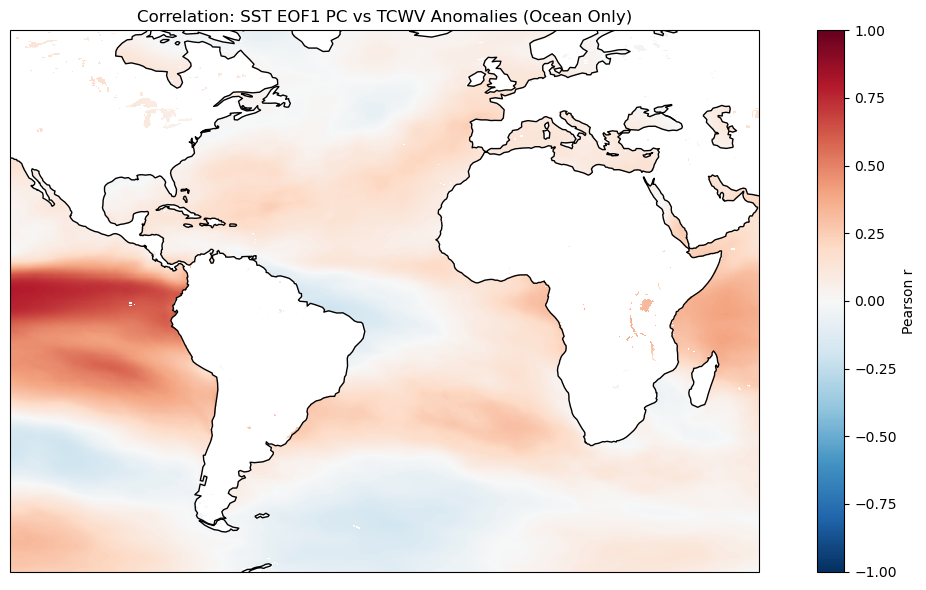

Mean correlation: 0.110
Max correlation: 0.793
Min correlation: -0.218
High positive correlation (>0.5) at 10448 grid points
